
# Laboratorio 3: Introducción al Aprendizaje Automático

> **Análisis de las Posiciones del Aborto en Twitter**
> *Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus aplicaciones.*
> *Integrantes: 
    - Carlos Piaggio
    - Juan Pablo Analian
> Pasos realizados
    - Levantamos el DF de salida del ejercicio anterior (lab 2)
    - quitamos las columnas que no usaremos.
    - dividimos el DS para entrenamiento y test
    - probamos la mayoría de los algoritmos de clasificacion vistos en clase
    - Finalmente seleccionamos un modelo justificando la respuesta

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from ml.visualization import plot_confusion_matrix, plot_learning_curve, classifier_boundary

 
from sklearn import tree
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

import sklearn.linear_model
from sklearn.linear_model import SGDClassifier,Perceptron
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
df_original = pd.read_csv('out/df_final.csv')

Validamos que no haya datos faltantes (todas las columnas tienen 370486 registros)

In [3]:
df_original.describe()

,Unnamed: 0,id,user_followers,user_friends,user_statuses,user_favourites,tweets_count,tweets_favorite_sum,tweets_retweet_sum,ht_contra,ht_favor,ht_indefinidos,no_clasificados
count,370486.000000,3.704860e+05,3.704860e+05,3.704860e+05,3.704860e+05,3.704860e+05,370486.000000,370486.000000,370486.000000,370486.000000,370486.000000,370486.00000,370486.000000
mean,185242.500000,2.082670e+17,1.979009e+03,7.186879e+02,1.655812e+04,8.866667e+03,3.137735,5.989411,2.164902,1.764274,3.914056,4.80836,52.894395
std,106950.240253,3.768441e+17,5.567966e+04,3.874823e+03,3.969058e+04,1.759868e+04,8.758238,238.831972,89.439934,8.585051,10.905914,13.71734,145.920656
min,0.000000,3.971000e+03,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,92621.250000,3.108181e+08,1.140000e+02,1.850000e+02,1.590000e+03,9.380000e+02,1.000000,0.000000,0.000000,0.000000,1.000000,1.00000,17.000000
50%,185242.500000,1.401110e+09,3.230000e+02,3.680000e+02,6.632000e+03,3.433000e+03,1.000000,0.000000,0.000000,0.000000,2.000000,2.00000,22.000000
75%,277863.750000,4.636328e+09,7.480000e+02,7.170000e+02,1.920600e+04,9.713000e+03,3.000000,0.000000,0.000000,2.000000,4.000000,4.00000,44.000000
max,370485.000000,1.025411e+18,1.662782e+07,1.047219e+06,9.063783e+06,1.084250e+06,757.000000,60736.000000,25144.000000,964.000000,1116.000000,1172.00000,12793.000000


In [4]:
df_original.head(5)

,Unnamed: 0,id,hashed_name,verified,created_at,user_followers,user_friends,user_statuses,user_favourites,tweets_count,tweets_favorite_sum,tweets_retweet_sum,ht_contra,ht_favor,ht_indefinidos,no_clasificados,posicion
0,0,19398656,d5172b6972ac058149c18f43b85b0c65,False,2009-01-23 15:38:24+00:00,427,791,50613,10199,9,1,0,8.0,13.0,13.0,152.0,a favor
1,1,791841268879851520,a977df035bf9ac28b4ec811a03427fd4,False,2016-10-28 03:17:25+00:00,722,178,18823,13596,1,0,0,2.0,0.0,0.0,9.0,en contra
2,2,2680160258,70fbe6e143195028b48a0f997d25c941,False,2014-07-25 18:07:57+00:00,1390,1107,6576,13425,1,0,0,0.0,0.0,2.0,18.0,indefinido
3,3,260492029,0a1b84dcf42fd3371b6d9de79c84295f,False,2011-03-04 00:15:24+00:00,631,876,3130,11690,1,2,0,0.0,1.0,1.0,6.0,a favor
4,4,574707030,489539e42b7ecdfee7d4caaf492891e2,False,2012-05-08 16:59:21+00:00,1174,360,25947,9978,7,0,0,2.0,5.0,8.0,113.0,a favor


Para generar el conjunto de datos con el que vamos a trabajar tomamos las siguiente determinaciones:

Eliminamos los registros que nosotros indentificamos como indefinidos, para solo trabajar con la identificación propuesta (A favor o en contra) de forma de considerar el problema como una clasificación binaria.

Por otro lado excluimos las columnas con datos que habíamos generado para nosotros determinar las etiquetas, ya que si dejamos estas columnas la correlación con la etiqueta afectaría el modelo ya que con solo esa feature podría predecir. 


In [5]:
df = df_original.loc[df_original.posicion != 'indefinido',
                     ['posicion', 'verified','user_followers', 'user_friends','user_statuses','user_favourites','tweets_count','tweets_favorite_sum','tweets_retweet_sum']]

In [6]:
df.head(5)

,posicion,verified,user_followers,user_friends,user_statuses,user_favourites,tweets_count,tweets_favorite_sum,tweets_retweet_sum
0,a favor,False,427,791,50613,10199,9,1,0
1,en contra,False,722,178,18823,13596,1,0,0
3,a favor,False,631,876,3130,11690,1,2,0
4,a favor,False,1174,360,25947,9978,7,0,0
5,a favor,False,18,44,921,4075,12,0,0


Realizamos un recuento de las etiquetas a favor y en contra para entender el balanceo. 

In [7]:
df.posicion.value_counts(normalize=True)

a favor      0.821262
en contra    0.178738
Name: posicion, dtype: float64

In [8]:
LABELS = ['a favor','en contra']

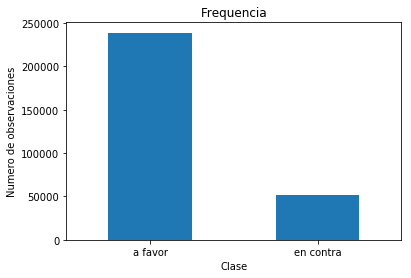

In [9]:
count_classes = pd.value_counts(df['posicion'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequencia")
plt.xlabel("Clase")
plt.ylabel("Numero de observaciones");

> Aprox el 82.1% de las etiquetas pertenecen a la clase "a favor" y el 17.9% a la clase "en contra"

## Carga de datos, estandarización de datos y división entre entrenamiento y validación


Definimos y seleccionamos la función de "estandarización" los datos. Descartamos la normalización de los mismos ya que cualquier nuevo valor que supere las cantidades definidas en el DS, podrá generar error en el modelo. (es probable que al sumar información de un nuevo usuario de twitter, tenga mas seguidores, o tweets o favs que los presentes en este data set).

In [10]:
def estandarizar(X):
    mean = X.mean()
    std = X.std()
    return (X - mean) / std

In [11]:
# Modificamos la variables que estaban como string para que queden en 0 y 1.
df.verified = df.verified.replace({True:1, False:0})
df.posicion = df.posicion.replace({'a favor': 1, 'en contra':0})

In [12]:
df.head(5)

,posicion,verified,user_followers,user_friends,user_statuses,user_favourites,tweets_count,tweets_favorite_sum,tweets_retweet_sum
0,1,0,427,791,50613,10199,9,1,0
1,0,0,722,178,18823,13596,1,0,0
3,1,0,631,876,3130,11690,1,2,0
4,1,0,1174,360,25947,9978,7,0,0
5,1,0,18,44,921,4075,12,0,0


Dividimos entre features y etiquetas y estandarizamos las features

In [13]:
# División entre instancias y etiquetas
X, y = df.iloc[:, 1:], df.posicion #Eliminamos la columna Posicion para el dataframe X
X = estandarizar(X) # Estandarizamos las features

In [14]:
X.head(5)

,verified,user_followers,user_friends,user_statuses,user_favourites,tweets_count,tweets_favorite_sum,tweets_retweet_sum
0,-0.051164,-0.026781,0.020662,0.854955,0.064299,0.547499,-0.023849,-0.026693
1,-0.051164,-0.021724,-0.167256,0.051689,0.254237,-0.268704,-0.027573,-0.026693
3,-0.051164,-0.023284,0.046719,-0.344840,0.147666,-0.268704,-0.020125,-0.026693
4,-0.051164,-0.013976,-0.111463,0.231697,0.051942,0.343449,-0.027573,-0.026693
5,-0.051164,-0.033793,-0.208334,-0.400657,-0.278113,0.853576,-0.027573,-0.026693


In [15]:
y.head(5)

0    1
1    0
3    1
4    1
5    1
Name: posicion, dtype: int64

In [16]:
# división entre entrenamiento y test. Seleccionamos un 80% de los datos para entrenamiento y nos queda un 20% para Test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
Counter(y_train), Counter(y_test)

(Counter({1: 190966, 0: 41598}), Counter({1: 47779, 0: 10362}))

## Definimos los métodos que utilizaremos para los modelos

In [18]:
def mostrar_resultados(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])  #, labels=[1,0]
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix,  annot=True, fmt="d"); #xticklabels=[1,0], yticklabels=[1,0],
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print ("Accuracy score (train):  %.2f" % accuracy_score(y_test, y_pred))
    print ("=============================")
    print (classification_report(y_test, y_pred, labels=[1,0], target_names=LABELS))

In [19]:
## solo para modelos que pueden precedir probabilidad.
def mostrar_curva_roc(X_test, y_test, mod):
    try:    
        y_pred_proba = mod.predict_proba(X_test)[::,1]    
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(4,4))
        lw = 2
        plt.plot(fpr, tpr,  lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title('Curva ROC')
        plt.legend(loc=4)
        plt.show()
    except Exception as e:
        print("") #no todos los mdelos predicen
        #print("Error: " + str(e))

## Iniciamos la prueba de los clasificadores 

Siendo que este es un problema de clasificación (tenemos que definir si un usuario está  a favor o encontra) comenzamos a probar con algoritmos clasificadores. 


> Evaluaremos el accuracy (respecto a los datos de test) de cada uno de los modelos que propongamos, para seleccionar el mejor algoritmo de predicción de las clases. En caso de que este valor sea similar en varios de ellos, podremos tomar los valores de "precision" y "recall" para definir el mejor.

In [20]:
resultados = []
resultados.clear()

### 1- Clasificador SDG

Hemos aplicado el cross validation con este clasficador, pero ha tomado mucho tiempo en llegar a los mejores hiperparámetros, que hemos decidido utilizar estos, en una sola corrida del mismo.

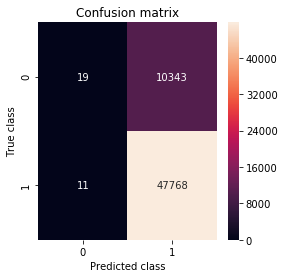

Accuracy score (train):  0.82
              precision    recall  f1-score   support

     a favor       0.82      1.00      0.90     47779
   en contra       0.63      0.00      0.00     10362

    accuracy                           0.82     58141
   macro avg       0.73      0.50      0.45     58141
weighted avg       0.79      0.82      0.74     58141



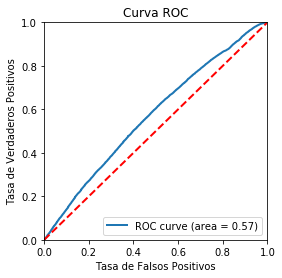

In [21]:
model_sdg =SGDClassifier (loss='log', penalty='l2', alpha=0.01, 
                          learning_rate='optimal', eta0 = 0.1, tol=1e-3,  
                          max_iter= 1000, random_state=42)

model_sdg.fit(X_train, y_train)
y_pred = model_sdg.predict(X_test)

mostrar_resultados(y_test, y_pred)
mostrar_curva_roc(X_test,y_test,model_sdg)

model = {'model': '1-SGD', 'accuracy': accuracy_score(y_test, y_pred)}
resultados.append (model)

### 2- Clasificador Perceptrón
Teniendo en cuenta que estamos ante un problema de clasificación binaria, podemos aplicar el clasificador Perceptrón.

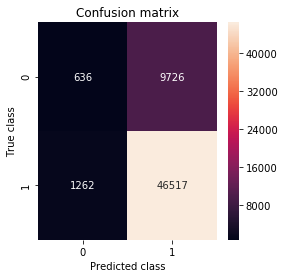

Accuracy score (train):  0.81
              precision    recall  f1-score   support

     a favor       0.83      0.97      0.89     47779
   en contra       0.34      0.06      0.10     10362

    accuracy                           0.81     58141
   macro avg       0.58      0.52      0.50     58141
weighted avg       0.74      0.81      0.75     58141




In [22]:
penalty = 'l2' # TODO: Tipo de regularización: l1 (valor absoluto), l2 (cuadrados), elasticnet (l1 + l2).
alpha = 0.0001 # TODO: Parámetro de regularización. También denominado como parámetro `lambda`.
max_iter = 1000 # TODO: Cantidad máxima de iteraciones del algoritmo

model_p = Perceptron(penalty=penalty, alpha=alpha, max_iter=max_iter, tol=None)
model_p.fit(X_train, y_train)

y_pred = model_p.predict(X_test)
mostrar_resultados(y_test, y_pred)
mostrar_curva_roc(X_test,y_test,model_p)

model = {'model': '2-Perceptron', 'accuracy': accuracy_score(y_test, y_pred)}
resultados.append(model)

### 3- Naive Bayes

Como tercera opcion consideramos Naive bayes

Utilizamos el tipo de algoritmo Gaussiano ya que está orientado a trabajar con variables continuas, como quedaron las neustras despues de la estandarización.  

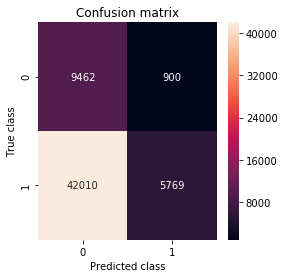

Accuracy score (train):  0.26
              precision    recall  f1-score   support

     a favor       0.87      0.12      0.21     47779
   en contra       0.18      0.91      0.31     10362

    accuracy                           0.26     58141
   macro avg       0.52      0.52      0.26     58141
weighted avg       0.74      0.26      0.23     58141



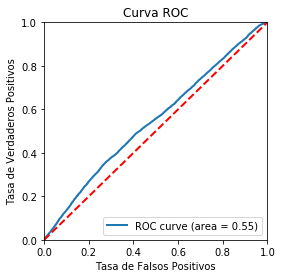

In [23]:
model_g = GaussianNB()
model_g.fit(X_train, y_train)
y_pred = model_g.predict(X_test)

mostrar_resultados(y_test, y_pred)
mostrar_curva_roc(X_test,y_test,model_g)

model = {'model': '3-Naive Bayes', 'accuracy': accuracy_score(y_test, y_pred)}
resultados.append(model)

### 4- Naive Bayes Multinomial

Para probar con la variante multinomial volvemos a levantar los datos sin estandarizar

In [24]:
# volvemos a levantar los datos sin estandarizar ya que NB Multinomial no permite valores decimales.
X_NS, y_NS = df.iloc[:, 1:], df.posicion #Eliminamos la columna Posicion para el dataframe X
X_train_NS, X_test_NS, y_train_NS, y_test_NS = train_test_split(X_NS, y_NS, test_size=0.2, random_state=0)

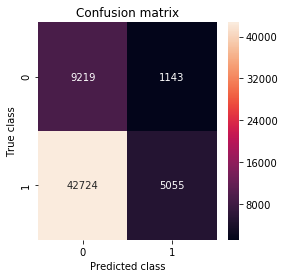

Accuracy score (train):  0.25
              precision    recall  f1-score   support

     a favor       0.82      0.11      0.19     47779
   en contra       0.18      0.89      0.30     10362

    accuracy                           0.25     58141
   macro avg       0.50      0.50      0.24     58141
weighted avg       0.70      0.25      0.21     58141



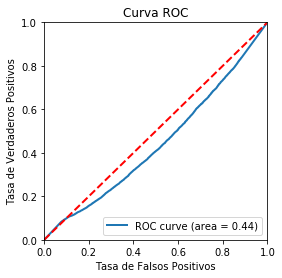

In [25]:
model_m = MultinomialNB()
model_m.fit(X_train_NS, y_train_NS)
y_pred = model_m.predict(X_test_NS)

mostrar_resultados(y_test_NS, y_pred)
mostrar_curva_roc(X_test_NS,y_test_NS,model_m)

model = {'model': '4-Naive Bayes Multinomial', 'accuracy': accuracy_score(y_test_NS, y_pred)}
resultados.append(model)


### 5- KNN (Nearest Neighbors)

Si bien estamos ante un problema de clasificacion binaria, queremos realizar una prueba con el algoritmo KNN el cual está mas orientado a clasificacion multiclase. 

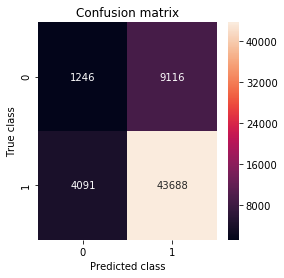

Accuracy score (train):  0.77
              precision    recall  f1-score   support

     a favor       0.83      0.91      0.87     47779
   en contra       0.23      0.12      0.16     10362

    accuracy                           0.77     58141
   macro avg       0.53      0.52      0.51     58141
weighted avg       0.72      0.77      0.74     58141



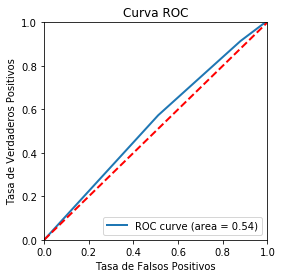

In [26]:
model_k = KNeighborsClassifier(n_neighbors=3)
model_k.fit(X_train, y_train)
y_pred = model_k.predict(X_test)

mostrar_resultados(y_test, y_pred)
mostrar_curva_roc(X_test,y_test,model_k)

model = {'model': '5-K Nearest Neighbors', 'accuracy': accuracy_score(y_test, y_pred)}
resultados.append(model)

### 6- Regresion Logistica
Vamos a determinar la probabilidad

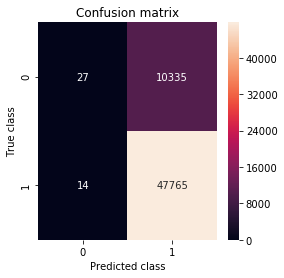

Accuracy score (train):  0.82
              precision    recall  f1-score   support

     a favor       0.82      1.00      0.90     47779
   en contra       0.66      0.00      0.01     10362

    accuracy                           0.82     58141
   macro avg       0.74      0.50      0.45     58141
weighted avg       0.79      0.82      0.74     58141



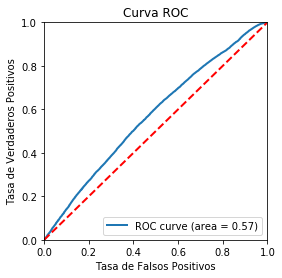

In [27]:
model_l = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')
model_l.fit(X_train, y_train)
y_pred = model_l.predict(X_test)

mostrar_resultados(y_test, y_pred)
mostrar_curva_roc(X_test,y_test, model_l)

model = {'model': '6-LogisticRegression', 'accuracy': accuracy_score(y_test, y_pred)}
resultados.append(model)

### 7- Regresion logistica con "undersampling"

Probaremos el mismo algoritmo, pero con la misma cantidad de muestras de las 2 clases, reduciendo las muestras de la clase "a favor" en forma aleatoria.

In [28]:
q_afavor = len(df[df.posicion == 1])
q_encontra = len(df[df.posicion == 0])

afavor_indices = df[df.posicion == 1].index
random_indices = np.random.choice(afavor_indices,q_encontra, replace=False)

encontra_indices = df[df.posicion == 0].index

under_sample_indices = np.concatenate([encontra_indices,random_indices])
under_sample = df.loc[under_sample_indices]

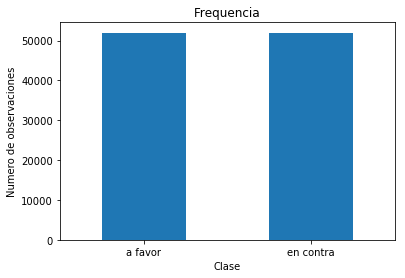

In [29]:
count_classes = pd.value_counts(under_sample['posicion'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequencia")
plt.xlabel("Clase")
plt.ylabel("Numero de observaciones");

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


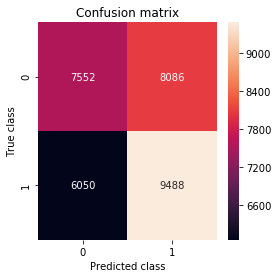

Accuracy score (train):  0.55
              precision    recall  f1-score   support

     a favor       0.54      0.61      0.57     15538
   en contra       0.56      0.48      0.52     15638

    accuracy                           0.55     31176
   macro avg       0.55      0.55      0.54     31176
weighted avg       0.55      0.55      0.54     31176



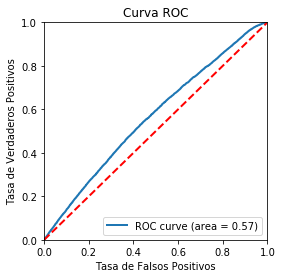

In [30]:
X_under = under_sample.loc[:,under_sample.columns != 'posicion']
y_under = under_sample.loc[:,under_sample.columns == 'posicion']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,test_size = 0.3, random_state = 42)

model_lr_under = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')
model_lr_under.fit(X_under_train,y_under_train)
 
y_pred = model_lr_under.predict(X_under_test)    
    
mostrar_resultados(y_under_test, y_pred)
mostrar_curva_roc(X_under_test,y_under_test,model_lr_under)


model = {'model': '7-LogisticRegression undersampling', 'accuracy': accuracy_score(y_under_test, y_pred)}
resultados.append(model)

### 8- Regresion logistica "balanceada"
Probaremos ahora el parametro class_weigt = 'balanced' para quilibrar a la clase minoritaria durante el entrenamiento.

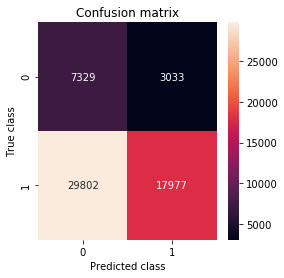

Accuracy score (train):  0.44
              precision    recall  f1-score   support

     a favor       0.86      0.38      0.52     47779
   en contra       0.20      0.71      0.31     10362

    accuracy                           0.44     58141
   macro avg       0.53      0.54      0.42     58141
weighted avg       0.74      0.44      0.48     58141



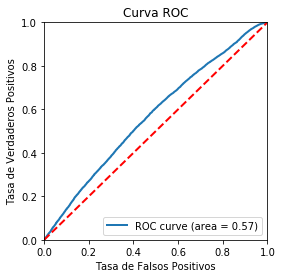

In [31]:
model_l2 = LogisticRegression(C=1.0 , random_state=42,penalty='l2', solver='liblinear', class_weight="balanced")
model_l2.fit(X_train, y_train)
y_pred =  model_l2.predict(X_test)

mostrar_resultados(y_test, y_pred)
mostrar_curva_roc(X_test, y_test, model_l2)
 
model = {'model': '8-LogisticRegression balanced', 'accuracy': accuracy_score(y_test, y_pred)}
resultados.append(model)

### 9- Arboles de decisión

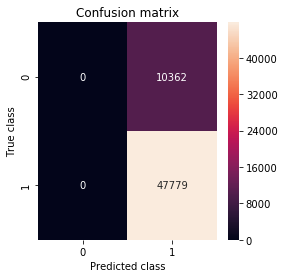

Accuracy score (train):  0.82
              precision    recall  f1-score   support

     a favor       0.82      1.00      0.90     47779
   en contra       0.00      0.00      0.00     10362

    accuracy                           0.82     58141
   macro avg       0.41      0.50      0.45     58141
weighted avg       0.68      0.82      0.74     58141



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


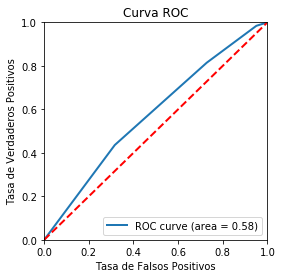

In [32]:
model_t = tree.DecisionTreeClassifier(max_depth=2, random_state=42)
model_t.fit(X_train, y_train)
y_pred = model_t.predict(X_test)

mostrar_resultados(y_test,y_pred )
mostrar_curva_roc(X_test,y_test,model_t)


model = {'model': '9-DecisionTree', 'accuracy': accuracy_score(y_test, y_pred)}
resultados.append(model)

### 10- SVM 

(Este es el algoritmo que mas demora, 10 minutos)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


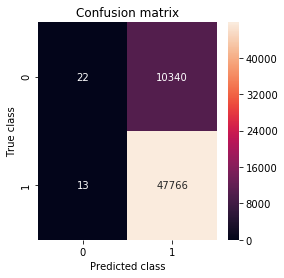

Accuracy score (train):  0.82
              precision    recall  f1-score   support

     a favor       0.82      1.00      0.90     47779
   en contra       0.63      0.00      0.00     10362

    accuracy                           0.82     58141
   macro avg       0.73      0.50      0.45     58141
weighted avg       0.79      0.82      0.74     58141




In [33]:
model_svm = sklearn.svm.LinearSVC(max_iter=5000)
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)

mostrar_resultados(y_test, y_pred)
mostrar_curva_roc(X_test,y_test,model_svm)

model = {'model': '10-SVM', 'accuracy': accuracy_score(y_test, y_pred)}
resultados.append(model)

### 11- Random Forest
(menos de 2 minutos)

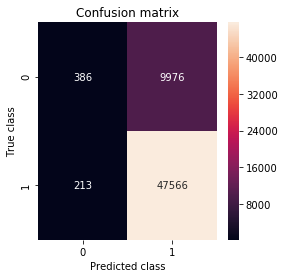

Accuracy score (train):  0.82
              precision    recall  f1-score   support

     a favor       0.83      1.00      0.90     47779
   en contra       0.64      0.04      0.07     10362

    accuracy                           0.82     58141
   macro avg       0.74      0.52      0.49     58141
weighted avg       0.79      0.82      0.75     58141



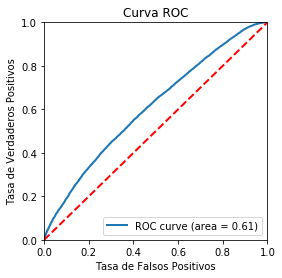

In [34]:
model_rf = RandomForestClassifier(n_estimators= 100, max_depth = 20, min_samples_split=10, random_state=42)    
model_rf.fit(X_train, y_train)    
y_pred = model_rf.predict(X_test)    
    
mostrar_resultados(y_test, y_pred)    
mostrar_curva_roc(X_test,y_test,model_rf)


model = {'model': '11-Random Forest', 'accuracy': accuracy_score(y_test, y_pred)}
resultados.append(model)

## Ranking (segun el accuracy)

In [35]:
df = pd.DataFrame.from_dict(resultados)
cols = sorted(df.columns, reverse=True)
df = df.reindex(cols, axis=1)

df["ranking"] = df["accuracy"].rank(ascending=False)
df.sort_values(by='ranking', inplace=True)

df

,model,accuracy,ranking
10,11-Random Forest,0.824754,1.0
5,6-LogisticRegression,0.822002,2.0
9,10-SVM,0.821933,3.0
0,1-SGD,0.821916,4.0
8,9-DecisionTree,0.821778,5.0
1,2-Perceptron,0.811011,6.0
4,5-K Nearest Neighbors,0.772845,7.0
6,7-LogisticRegression undersampling,0.546574,8.0
7,8-LogisticRegression balanced,0.435252,9.0
2,3-Naive Bayes,0.261967,10.0


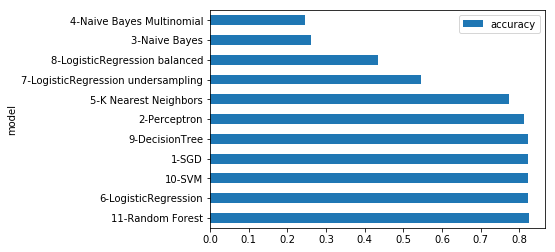

In [36]:
ax = df.plot.barh(x='model', y='accuracy', rot=0)

## Conclusiones
> Basandonos en la metrica seleccionada en un principio, podríamos decir que el clasificador Random Forest, es quien mayor precisión tiene a la hora de predecir. Aunque éste (y la gran mayoría) no detecte de la mejor manera a la clase "en contra", como lo indica el "recall".

> Al tratar con este dominio, podríamos afirmar que este clasificar podrá predecir con un % 83 de exactitud si nuestra pregunta es: "está a favor del aborto"?. 

> No podremos afirmar lo inverso, ya que el modelo no representa muy bien a la clase "en contra".